In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-02-18 09:43:50--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2023-02-18 09:43:51 (2.07 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
print(len(words))
min(len(w) for w in words) # 가장 짧은 단어
max(len(w) for w in words) # 가장 긴 단어

32033


2

"character language model" 은 지금까지 나타난 단어 sequence 다음에 나타날 글자를 예측 ( 다음 알파벳이 무엇인가? )
isabella 를 예로들면
i다음에 s
is 다음에 a
isa 다음에 b

그리고, isabella 가 나오면 [END] 라는걸.

일단 간단하게 markov assumption으로, 바로 직전의 character만 다음 character에 영향을 미친다고 해보자.

In [6]:
for w in words[:3]: #각 단어를 두개의 알파벳씩 slide하고싶어.
    print(w)
    for ch1, ch2 in zip(w, w[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        print(ch1, ch2)

emma
e m
m m
m a
olivia
o l
l i
i v
v i
i a
ava
a v
v a


In [8]:
# 단 위에처럼 하면, 첫단어와 마지막 단어라는 것을 몰라
for w in words[:1]: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["<S>"] + list(w) + ['<E>'] # list(w) 해야 <S> 가 하나의 string으로 인식시킬 수 있으니까
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


In [9]:
b = {}
for w in words[:1]: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["<S>"] + list(w) + ['<E>'] # list(w) 해야 <S> 가 하나의 string으로 인식시킬 수 있으니까
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram,0) + 1
        

In [10]:
b

{('<S>', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '<E>'): 1}

In [13]:
b = {}
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["<S>"] + list(w) + ['<E>'] # list(w) 해야 <S> 가 하나의 string으로 인식시킬 수 있으니까
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram,0) + 1
print(b[('<S>','e')])

1531


In [15]:
#sorted(b.items(),key=lambda kv: kv[1],reversed=True) #count로 sort하기, 내림차순
sorted(b.items(),key=lambda kv: -kv[1]) # 'n' 이나 'a'로 끝나는게많다.


0


이제 해야할 건, 첫번째 character 뒤에 어떤 character가 나올 확률이 제일 높은지 확인하기

In [16]:
import torch

In [17]:
a= torch.zeros((3,5),dtype=torch.int32) 
a

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [18]:
a.dtype # torch의 default는 torch.float32

torch.float32

In [20]:
# torch는 index접근가능
a[1, 3] +=1
a[0, 0] = 5
a

tensor([[5., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
#우리에게는 알파벳 26개 + <S> + <E> 이렇게 28개가 존재. 
# 각 단어별로 뒤에 어떤 단어가 나올 확률이 높은지 tensor를 만들고 싶으니까 (28,28)을 만들어야 한다
N = torch.zeros((28,28), dtype=torch.int32)

근데 이걸 알파벳 -> 숫자로 매핑하려면 lookup table이 하나 필요해. (0 == a, 1== b 이런식으로 ) 그래서 tensor[0][1] 은 a 다음에 b가 나오는 횟수 가 될 수 있게 한다.


In [21]:
set(''.join(words)) # words는 list of names 인데, 이를 ''.join 하면서 johnbrianamy 가 된다. 이걸 set로 만드니까 중복된게 제거된다

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [24]:
chars = sorted(list(set(''.join(words)))) # a~z 순으로 sort되었으면 좋겠다
stoi = {s:i for i,s in enumerate(chars)} #string to integer to dict

In [25]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [26]:
stoi["<S>"]=26
stoi["<E>"]=27

In [27]:
N = torch.zeros((28,28),dtype=torch.int32)
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["<S>"] + list(w) + ['<E>'] # list(w) 해야 <S> 가 하나의 string으로 인식시킬 수 있으니까
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1


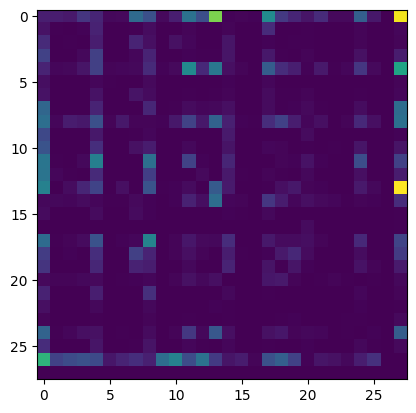

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N) # a 다음에 <E>(27)가 많네. == 끝나는게 엄청많네

In [29]:
# 더 보기좋게 할 방법이 없나? int를 string으로 만들어서 보여주자

itos = {i:s for s, i in stoi.items()}

(-0.5, 27.5, 27.5, -0.5)

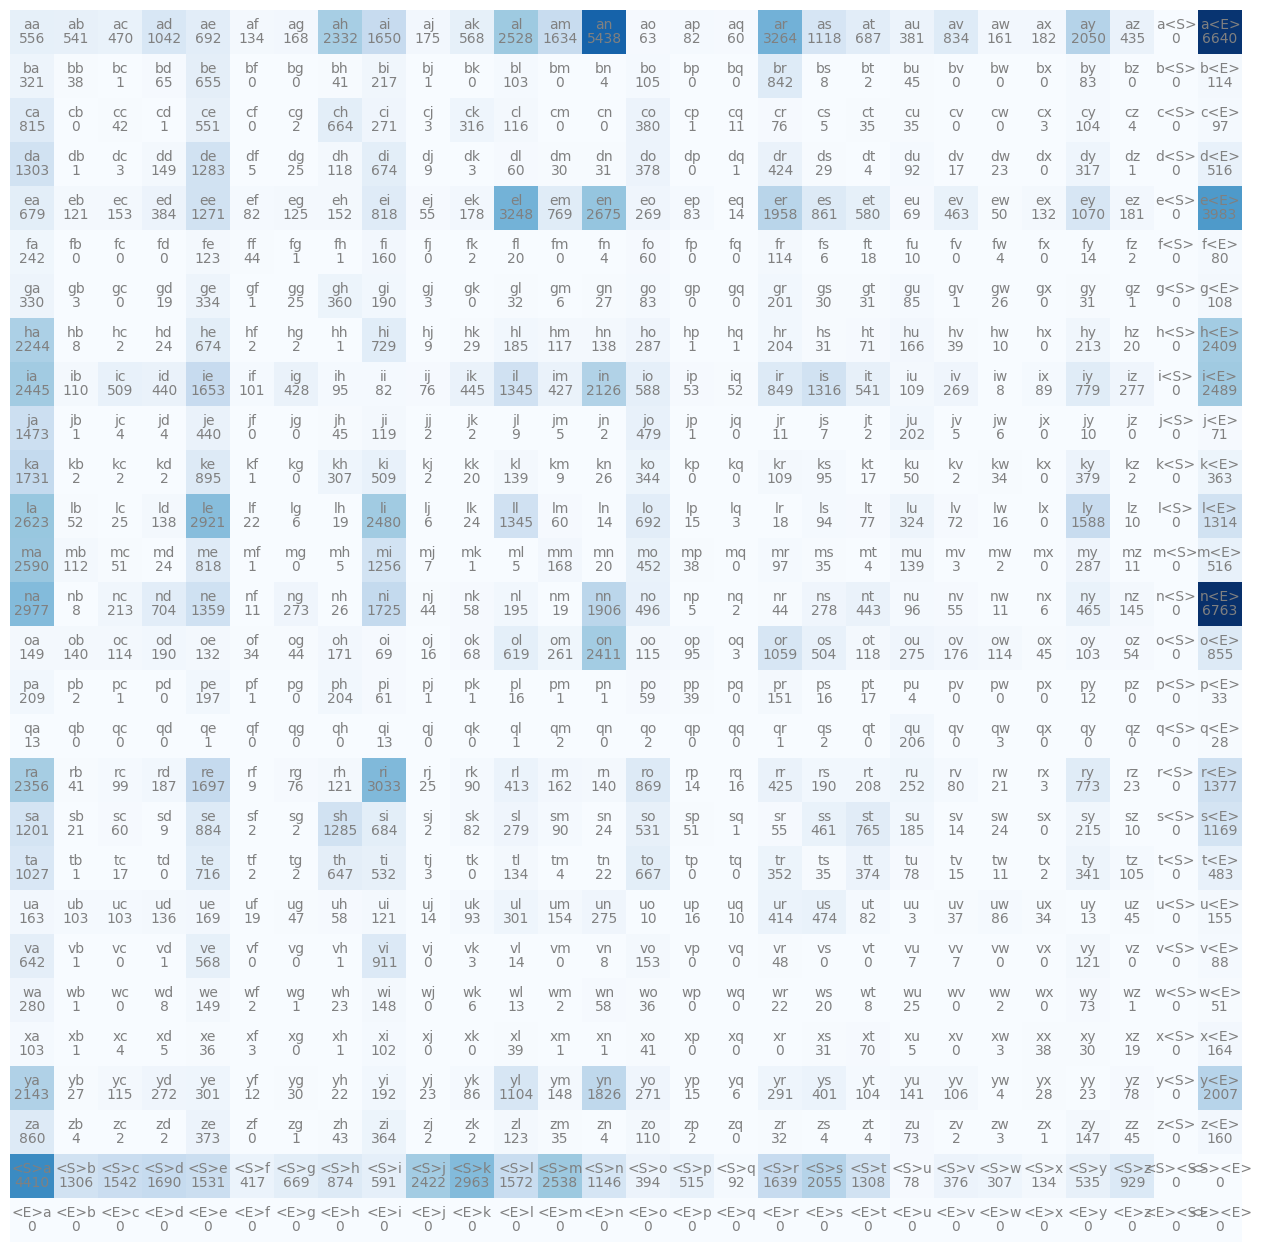

In [30]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [31]:
# N[i,j].item() 을 사용한 이유는
N[3,3] # 이게 여전히 tensor(149, dtype=torch.int32) tensor 타입이거든. N[3,3].item()을 해야지 149 하나가 나와.

tensor(149, dtype=torch.int32)

In [32]:
# <S>로 끝나는것, <E>로 시작하는건 없어. 0이야.
# 그러니, 더 현명하게, <S> , <E> 토큰대신 "." 토큰을 만들자
chars = sorted(list(set(''.join(words)))) # a~z 순으로 sort되었으면 좋겠다
stoi = {s:i+1 for i,s in enumerate(chars)} #string to integer to dict
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [33]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

(-0.5, 26.5, 26.5, -0.5)

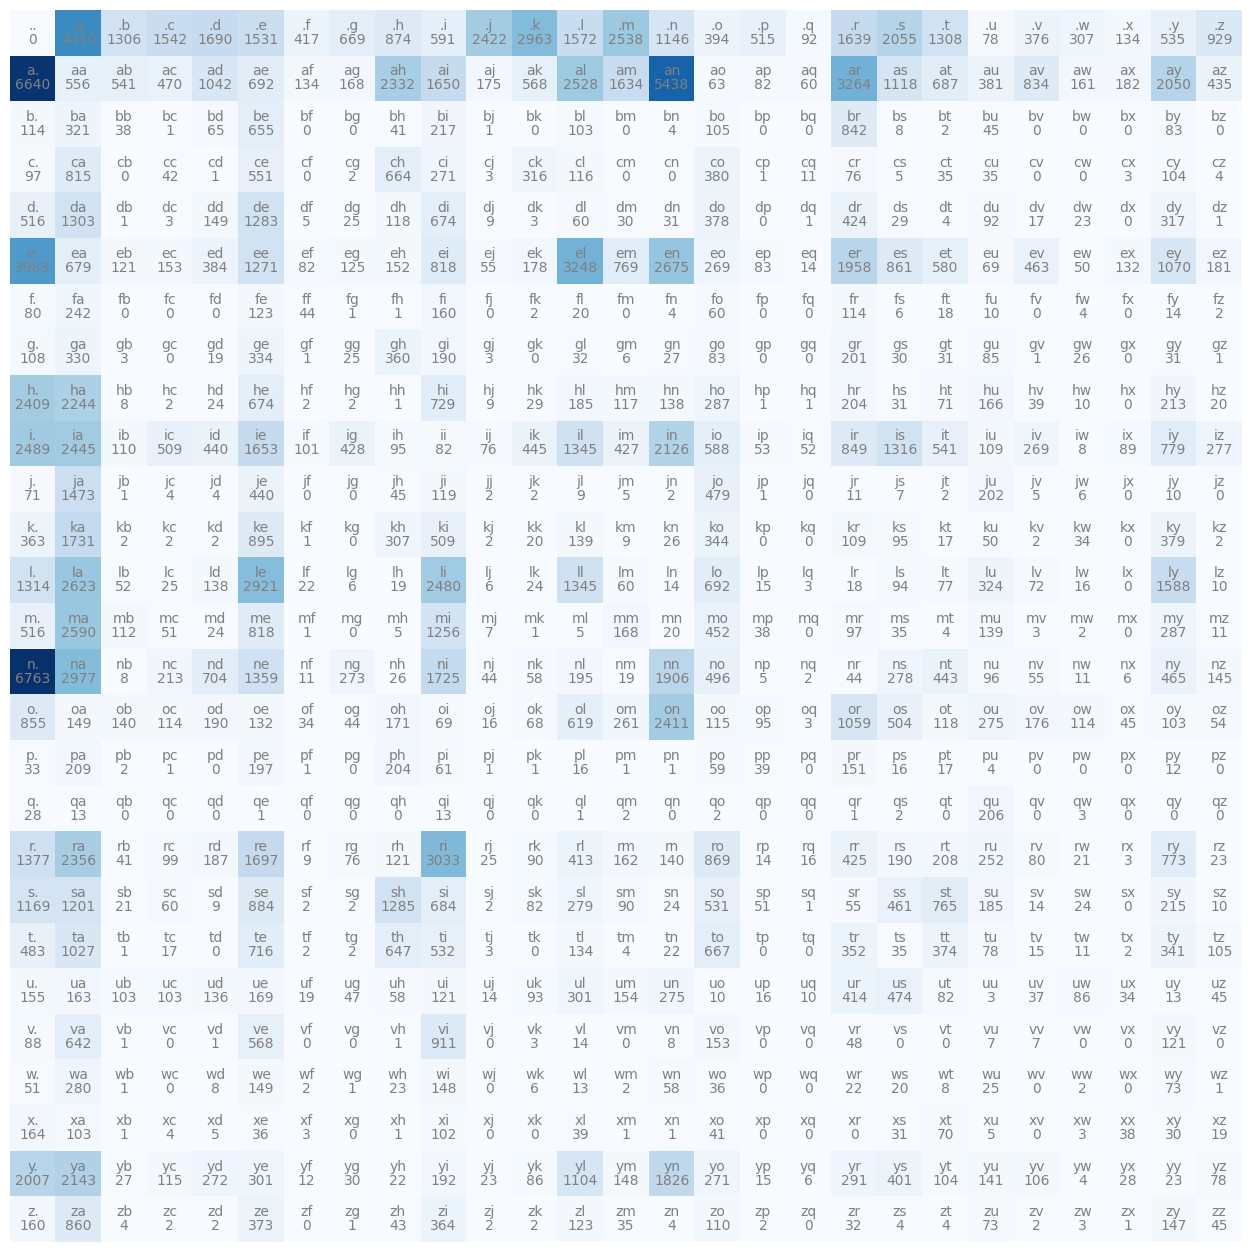

In [59]:
N = torch.zeros((27,27),dtype=torch.int32)
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1
        
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [60]:
# .. 이라는 empty word는 없으니까, 첫번째 단어로 시작하는것들과, 어떤 단어로 끝나는게 많은지 알 수 있다.

# 이제 임의로 단어를 만들어보자.
# N[0] # .a, .b, .c ...
N[0:]  # 위랑 같음 N[0:].shape = [1,27]

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

In [61]:
# 이제 이걸 probability로 전환해야해
p = N[0].float() # float으로 전환먼저 하고. 
p = p / p.sum() # sum으로 나눠서 '.'다음에 올 a,b,c,d,e... 의 확률이 된다.
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

# multinomial distribution 

torch.multinomial 함수가 존재한다.
torch.multinomial(input, num_samples, generator=None) 이렇게 있는데, 
input으로 확률들을 쭉 넘겨주면, 그걸로 확률 분포를 연속적으로 만들어낸다.
그러면, 그 확률 분포에 따라 num_samples 개수만큼 샘플을 리턴해준다. 

num_samples 를 주면, num_samples의 0번째가 가장 왼쪽의 확률, num_samples번째가 가장 오른쪽의 확률로 되어
vector로 나온다.


우리는 generator object를 사용한다. 그러면 랜덤한 샘플이 나오긴 하지만, 특정 랜덤시드를 거쳐서 나온다.
그래서 내가 샘플을 얻는것과, 동영상의 시청자가 샘플을 얻는게 동일하다

In [62]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
print(p) # 같은 generator object를 써서 계속 같은값이 나오게 된다.
p =p / p.sum()
print(p)

tensor([0.7081, 0.3542, 0.1054])
tensor([0.6064, 0.3033, 0.0903])


In [63]:
torch.multinomial(p,num_samples=20, replacement=True,generator=g) #이러면 20개의 int를 probability에 따라 받는다. [0]번째의 probability가 높아서(0.6064) 많이나온다.

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [64]:
# 다시 예제로 돌아가서, 
p = N[0].float() # float으로 전환먼저 하고. 
p = p / p.sum() # sum으로 나눠서 '.'다음에 올 a,b,c,d,e... 의 확률이 된다.
p #이런 probability를 만들었으니까,
g = torch.Generator().manual_seed(2147483647)
index = torch.multinomial(p,num_samples=1, replacement=True,generator=g) 
itos[index.item()] #first character로 m을 골랐다 ( 이 확률 분포에따라서. 즉 "." 다음에 나올 확률 분포를 통계적으로 만들었고, 그에따라서 첫번째 char로 뽑은게 m인것 )


'm'

In [65]:
g = torch.Generator().manual_seed(2147483647)
index =0 # start token
for i in range(50):
    index =0 
    out = [] 
    while True:
        p = N[index].float()
        p = p / p.sum()
        index = torch.multinomial(p,num_samples=1, replacement=True,generator=g).item()
        out.append(itos[index])
        if index == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrpin.
a.
wai.
kn.
jaieendenelele.
kianu.
eryly.
zeeieil.
kayvirgiynenn.
r.
t.
rja.
kronanurolin.
din.
elfr.
dikie.
s.
elarieiavelvalllaish.
eythann.
janianaeri.
ble.
ckiree.
l.
adgenoena.
naisaryan.
sialaitalyee.
cena.
lisarr.
bizyngor.


In [66]:

g = torch.Generator().manual_seed(2147483647)
index =0 # start token
for i in range(10):
    index =0 
    out = [] 
    while True:
        # p = N[index].float()
        # p = p / p.sum()
        p = torch.ones(27) / 27
        index = torch.multinomial(p,num_samples=1, replacement=True,generator=g).item()
        out.append(itos[index])
        if index == 0:
            break
    print(''.join(out))
    
" uniform distribution에서의 결과물 " 

qvsaayxbqrqmyqwuznivanukotdjvdhd.
qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu.
idcx.
cekmzucjnjoeovjvrggqrjr.
cfbhabkslpokc.
xtxwbpmknuusxdgzfexhwqpldpdnwzvkyxsqjforqqpfxstwkfoufhvwfhmsuyyotvcvvqpfcbydjcouhkajkhqnnpqmmllaordqy.
gszpw.
zlgijinangzzuulsyvqrufuawavsdbnwvlmrypvgrsfgpshgnmwafqmsjdvbhngvoiigxhkwdltrdkwnagzyknqv.
lfstdqigvncdoidetsukgdp.
cfpjsxeqjcsmjwguzes.


' uniform distribution에서의 결과물 '

In [68]:
P = N.float()
print(P.shape)
print(P.sum(0, keepdim=True))
print(P.sum(0, keepdim=True).shape)
# keepdim 을 없애면 그냥 1d- 배열이 나온다. 
print(P.sum(0).shape )

torch.Size([27, 27])
tensor([[32033., 33885.,  2645.,  3532.,  5496., 20423.,   905.,  1927.,  7616.,
         17701.,  2900.,  5040., 13958.,  6642., 18327.,  7934.,  1026.,   272.,
         12700.,  8106.,  5570.,  3135.,  2573.,   929.,   697.,  9776.,  2398.]])
torch.Size([1, 27])


torch.Size([27])

In [69]:
# 근데 우리가 원하는건 [1,27] 이 아니다. 이건 column의 sum인거야.
# [27,1] 이 나와야한다.
P = N.float()
P.sum(1,keepdim=True).shape # 1번째 dimension에 대해 합을 진행한다. (x,y,z)와 같이 나타내자나. 
# 0 dimension에 대해서 sum하면 [0][0], [1][0], [2][0] ... [i][0] 이 sum되는거지.
# 1 dimension에 대해서 sum하면 [0][0], [0][1], [0][2] ... [0][i] 이 sum되는거야.
# P = P / P.sum(1,keepdim=True) # 이게 가능한가? (27,27) 을 (27,1)로 나누려고 한다. 


torch.Size([27, 1])

P = P / P.sum(1,keepdim=True) # 이게 가능한가? (27,27) 을 (27,1)로 나누려고 한다. 

이건 broadcasting rule에 의해 결정이 된다.
Torch의 broadcasting semantics 라는 문서가 있다.
broadcastable == binary operation (+ - * / ) 가 가능하다.
아래 조건일때
1. 각 tensor가 최소 하나의 dimension이 있어야 하고
2. dimension size 만큼 반복할때, dimension size가 equal하거나, dimension중 하나의 shape이 1이거나, 아예 존재하지 않아야 한다.



In [70]:
# 27 27
# 27 1  dimension size가 equal 하고, 한쪽이 1이다. 고로 나눗셈이 가능하다.
# 27, 1 짜리를 어떻게 하냐면, 1짜리를 27만큼 늘린다. 그렇게 27,27을 만들어서 각 칼럼별 연산을 하게 된다.

P = P/P.sum(1,keepdim=True)


In [72]:
g = torch.Generator().manual_seed(2147483647)

"""
우리가 위에서 했던 것은, "." 다음에 올 확률들로 단순히 단어를 만들어보려고 한건데, 이제는 전체 N 을 다 써서 다음 단어를 사용해보자.
27*27 매트릭스를 각 row마다 합이 1이되는 probability distribution을 만들면, 특정 char이 나왔을 때, 다음 char은 해당 row의 probability distribution을 사용해서 뽑는다.
p=N
for row in p:
   row = row / row.sum()

"""

P = N.float() #P.sum()은 모든 매트릭스의 합을 주고, 우리는 row의 합을 원해
# torch.sum 의 documentation을 보면, dimension을 줄수도 있다. keepdim 도 있다. 
P = P/P.sum(1,keepdim=True)


for i in range(10):
    index =0 
    out = [] 
    while True:
        p = P[index]
        index = torch.multinomial(p,num_samples=1, replacement=True,generator=g).item()
        out.append(itos[index])
        if index == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


In [76]:
#broadcasting은 무서워.

P = N.float()
P = P/P.sum(1)
P.sum(1).shape # 이건 keepdim이 없어서 squeeze 되버려 ( dimension이 1인경우 없애버린다)

# 27,27 이고,
# 27  이니까 그래도 실행될 수 있잖아!
# 그럼 되긴하는데, 이상하게 돼. 



torch.Size([27])

### broadcasting rules

1. 벡터에 해당 dimension이 아예 없는경우에는 가장 작은 dimension에 align 한다.
27 27
   27
   
이렇게 되겠지.
2. 가장 작은 dimension부터 iteration을 진행한다. 다만, 벡터사이 dimension 맞추기를 진행한다.
  2.1 dimension이 없으면 dimension을 1로 넣는다.
      27 27
       1 27 
  이렇게 된다
  
  2.2 dimension이 1인게 있으면, 복제를 해서 상대 dimension과 크기를 맞춘다.
      27 27
      27 27


왜 keepdim을 하지 않으면 고장나는지 알겠지

keepdim을 하지 않으면
[27][27] 에서
sum(1) 을해서
[0][0~i]
[1][0~i] 

이런게 쌓여서
[27][1] 이 만들어진다. 그런다음에 squeeze되고.

그럼 얘는 row들의 sum인데,

keepdim을 하지 않아서 [27]로 squeeze가 되버리면

27 27 / 27 할때 

[1][27] 이 만들어지고, 

그러면 1->27로 확장될때, column별로 같은값을 갖게 돼
1 2 3
1 2 3
1 2 3
원래는 row별로 같은 값이 될 [27][1] 이었는데
1 1 1
2 2 2
3 3 3

In [77]:
P[:,0].sum()  

tensor(1.)

P= P/P.sum(1,keepdim=True)  이건 주의해야 하는게 새 변수를 만든다. P/= P.sum(... ) 을 해서 in place operation을 해야 한다.

# BIGRAM 모델 다음, training 모델

In [81]:
N = torch.zeros((27,27),dtype=torch.int32)
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1
P = N.float()
P/=P.sum(1,keepdim=True)

"""다시 초기화"""

'다시 초기화'

In [88]:
log_likelihood =0.0
n=0
for w in words[:3]: # <- 근데 words 에 ["andrejq"] 이렇게 넣으면 jq가 일어날 확률이 infinity라서, nll이 -inf가 나와. 사실 이게 바람직하지 않으니, fake count를 모든 값에 다 더해
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2] # 매 bigram이 나올때마다 probability를 보고 싶어.
        logprob = torch.log(prob)
        n+=1
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}') # 이게 -38 이 나왔는데, log(x)에서 x가 1에 가까워질수록 0에 가까워지잖아. 
# 확률 값이 작아질수록 더 음수가 된다. 
# 근데 우리는 loss function을 보통 정의하고 트레이닝을 시키는데, loss function은 작아질수록 좋은것. (손해가 적음) -로 invert하자. 
# 이 nll은 굉장히 좋은 loss function이다. lowest loss는 0에 가까워지고, higher loss는 무한대로 커진다. 
# 근데 우리가 보통 average를 알고 싶다. normalize 해야 한다. 그냥 몇개의 항목값이 있었는지로 나눠보자 (n개) ==> 우리가 주로 쓰는 loss function이다.
nll = -log_likelihood # negative log likelihood 
print(f'{nll=}')
print(f'{nll/n=}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856)
nll=tensor(38.7856)
nll/n=tensor(2.4241)


 만약 uniform distribution이면 위의 모든 bigram 확률이 1/27이겠지? 
 그러니 1/27보다 높은 확률들은 이 트레이닝 셋에서 뭔가 유용한 정보를 얻었다는 뜻
 quality를 measure 할 수 있는 single number를 얻을 수 없을까?

### MLE (Maximum Likelihood Estimation)
MLE는 likelihood를 높이는것. likelihood는 product of all P[ix1,ix2] 라고 할 수 있다.
즉, 최종 단어가 뽑힐만한 확률. 
좋은 모델일수록, 실제 있는 이름으로 한 위 확률들의 곱은 매우 높아야할것.
근데 product하면 0.xxx 끼리 곱하니까 너무 작아져. 그래서 log likelihood를 꺼냈어.
log함수는 0에서 1 사이가 monotonic하게 늘어나. 

또다른 장점은 log(a*b*c) = log(a) + log(b) + log(c) 연산량이 줄어들어.

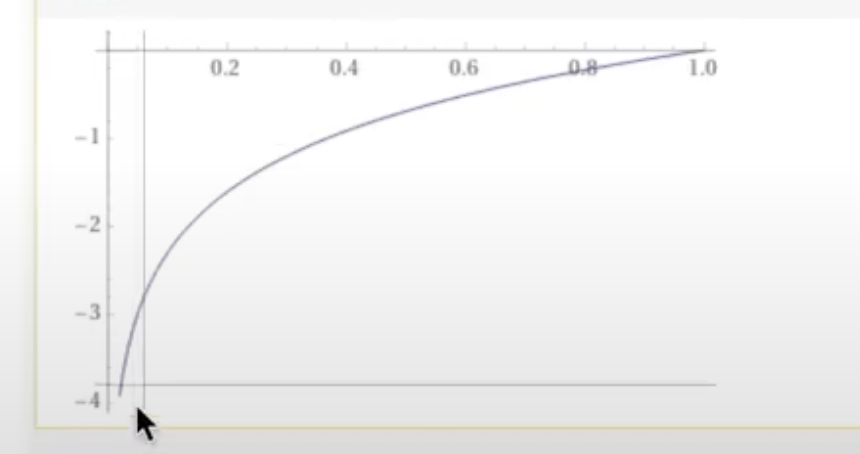


## Goal : Maximize likelihood of data w.r.t model parameters (statistical modeling)
equivalent to maximizing the log likelihood (log가 monotonic ( 계속 증가 ) 하니까) <br/>
equivalent to minimizing the negative log likelihood 
equivalent to minimizing the average negative log likelihood

그래서 우리는 negative log likelihood를 낮추는 작업을 할거다.
 

In [90]:
N = torch.zeros((27,27),dtype=torch.int32)
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] +=1
P = (N+1).float() #normalize 하려고 N+1

P/=P.sum(1,keepdim=True)


In [91]:
log_likelihood =0.0
n=0
for w in ["andrejq"]: # <- 근데 words 에 ["andrejq"] 이렇게 넣으면 jq가 일어날 확률이 infinity라서, nll이 -inf가 나와. 사실 이게 바람직하지 않으니, fake count를 모든 값에 다 더해
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2] # 매 bigram이 나올때마다 probability를 보고 싶어.
        logprob = torch.log(prob)
        n+=1
        log_likelihood += logprob
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}') # 이게 -38 이 나왔는데, log(x)에서 x가 1에 가까워질수록 0에 가까워지잖아. 
# 확률 값이 작아질수록 더 음수가 된다. 
# 근데 우리는 loss function을 보통 정의하고 트레이닝을 시키는데, loss function은 작아질수록 좋은것. (손해가 적음) -로 invert하자. 
# 이 nll은 굉장히 좋은 loss function이다. lowest loss는 0에 가까워지고, higher loss는 무한대로 커진다. 
# 근데 우리가 보통 average를 알고 싶다. normalize 해야 한다. 그냥 몇개의 항목값이 있었는지로 나눠보자 (n개) ==> 우리가 주로 쓰는 loss function이다.
nll = -log_likelihood # negative log likelihood 
print(f'{nll/n=}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
nll/n=tensor(3.4834)


In [93]:
# 이제 neural network를 만들건데, 
# single word를 input으로 받아서, probability distribution으로 다음에 나올 char을 예측한다.
# evaluation으로 loss function은 NLL 을 적용한다.
# gradient based optimization. 

# create training set of all biagrams (x,y) x가 주어졌을때 y를 예측하고싶은거

xs, ys = [] , [] #input, target label


for w in words[:1]: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)


. e
e m
m m
m a
a .


In [94]:
xs,ys # (tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))
# x가 0들어갔을때 5가 나오길바라고,
# x가 5일때 13
# x가 13일때 13
# 단 여기서, torch.Tensor, torch.tensor 두개가 다르다는 점을 유의? 


(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

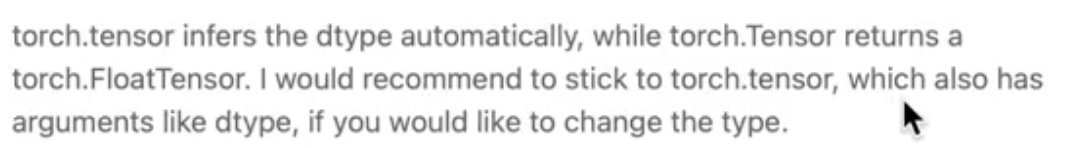
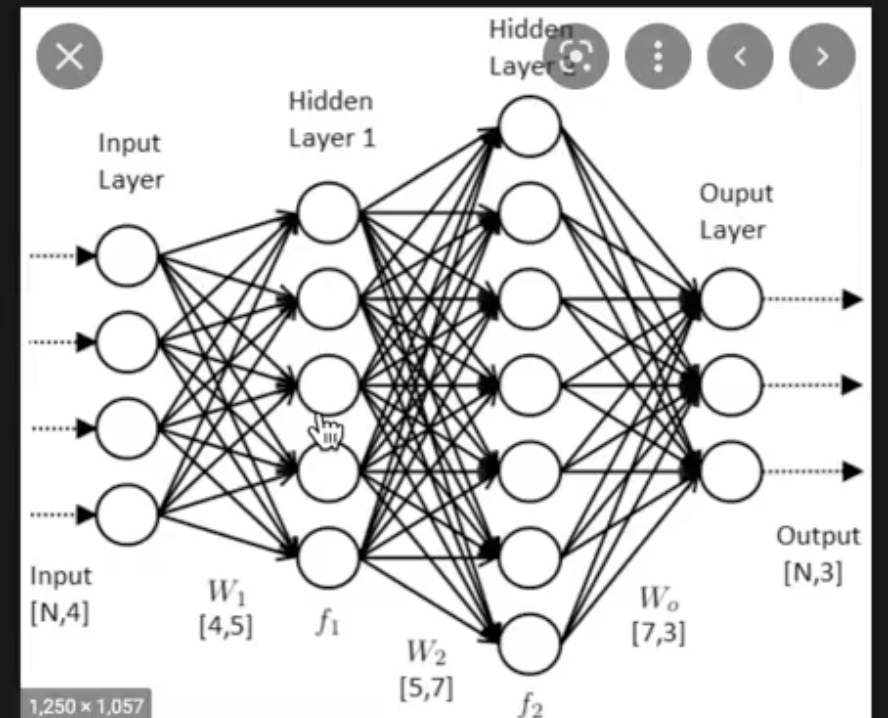

In [99]:
# 근데 지금 우리 input을 int로 받게 하면 안돼. 
# int를 weight에 곱하면 너무 힘들어.
# 그래서 우리는 one hot encoded vector를 만든다.

# torch.nn.functional.one_hot(tensor, num_classes=-1) 이란 함수가 있어. num_classes 는 벡터의 크기로 얼마를 원하는가
import torch.nn.functional as F

xenc = F.one_hot(xs,num_classes=27).float() # num_classes를 안줬으면 우리 tensor의 최대값이었던 13보다 1큰만큼 class가 있는건줄알아. (그래야 벡터의 마지막 index인 13에 1이 들어가겠지) 
print(xenc, xenc.shape)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]) torch.Size([5, 27])


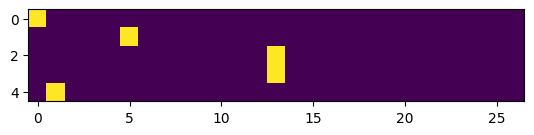

In [100]:
plt.imshow(xenc)

In [101]:
xenc.dtype # 헉 우리는 neural network에 데이터를 넣을때 항상 float이길 바란다. 근데 int64를 받았다. 그러니 float()을 붙여야한다.

torch.float32

In [104]:
W = torch.randn((27,1)) #  initial weight
print(W.shape)
xenc @ W # @이 matrix multiplication == matrix multiplication 하면 [5,1] 이 남는다.
# 우리가 5,27 을 27,1 에다가 넣었으니 (5,1) 결과물이 나오게 된다. 

torch.Size([27, 1])


tensor([[ 0.2327],
        [ 1.5217],
        [-0.8128],
        [-0.8128],
        [ 0.0343]])

In [109]:
W = torch.randn( (27,27) ) # 을 weight로 하면, 5,27 @ 27,27 하니까, 모든 5개 row에 대해서 27,27 매트릭스 곱을 한다. 5,27이 나온다.
print((xenc @ W).shape)
print( (xenc@W)[3,13] ) # 은 , 3번째 input을 넣었을때 13번째 뉴런이 뱉은 값. shape 뒤의거가 뉴런 하나하나 
(xenc[3] * W[:,13]).sum() # 이랑 똑같다. [0~n][13] 이랑 곱한값인거지.

#우리의 neural net은 (5,27) @ (27,27) -> (5,27) 의 구조를 만들었어. 그냥 레이어 하나있는거지. fully connected 27개가 27개로 들어와서 27개의 output을 만든다. == linear layer
# 우리는 이 27개의 결과물이 log(count)라고 보는거지. 그러니 exp( log(count)) 를 해버리자.
(xenc @ W).exp() # 모든 negative 숫자가 양수로 바뀌었다. 

logits = xenc @ W # log-count 
counts = logits.exp() # array of count 였던 N 배열같은거야. 
probs = counts / counts.sum(1,keepdims=True) # [0][dim번째가 바뀌어. 0~n] [1][0~n] [2][0~n] ... 
print(probs,probs.shape)
#counts와 probs 구하는 과정을 합쳐서 softmax activation function으로 부른다. 


torch.Size([5, 27])
tensor(0.9321)
tensor([[0.0179, 0.0324, 0.0104, 0.0244, 0.0217, 0.0535, 0.0058, 0.0276, 0.0921,
         0.0194, 0.0167, 0.0288, 0.0209, 0.0267, 0.0381, 0.0189, 0.0030, 0.0060,
         0.0119, 0.2452, 0.0047, 0.0372, 0.0157, 0.1038, 0.0439, 0.0598, 0.0135],
        [0.0536, 0.0095, 0.2109, 0.0054, 0.0103, 0.0593, 0.0557, 0.0376, 0.0696,
         0.0274, 0.0408, 0.0073, 0.0802, 0.0170, 0.0527, 0.0194, 0.0252, 0.0030,
         0.0166, 0.0481, 0.0091, 0.0183, 0.0478, 0.0079, 0.0197, 0.0396, 0.0080],
        [0.0680, 0.0069, 0.0031, 0.0298, 0.0113, 0.0589, 0.0499, 0.0051, 0.0064,
         0.0587, 0.0792, 0.0440, 0.0310, 0.0554, 0.0776, 0.0401, 0.0105, 0.0422,
         0.0163, 0.0071, 0.0262, 0.0308, 0.0558, 0.0268, 0.1165, 0.0333, 0.0094],
        [0.0680, 0.0069, 0.0031, 0.0298, 0.0113, 0.0589, 0.0499, 0.0051, 0.0064,
         0.0587, 0.0792, 0.0440, 0.0310, 0.0554, 0.0776, 0.0401, 0.0105, 0.0422,
         0.0163, 0.0071, 0.0262, 0.0308, 0.0558, 0.0268, 0.1165, 0.0333

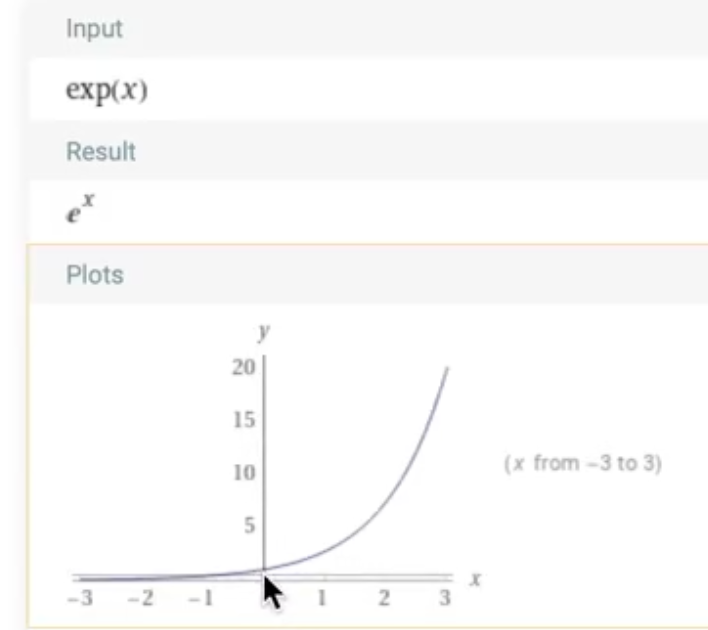

### softmax function
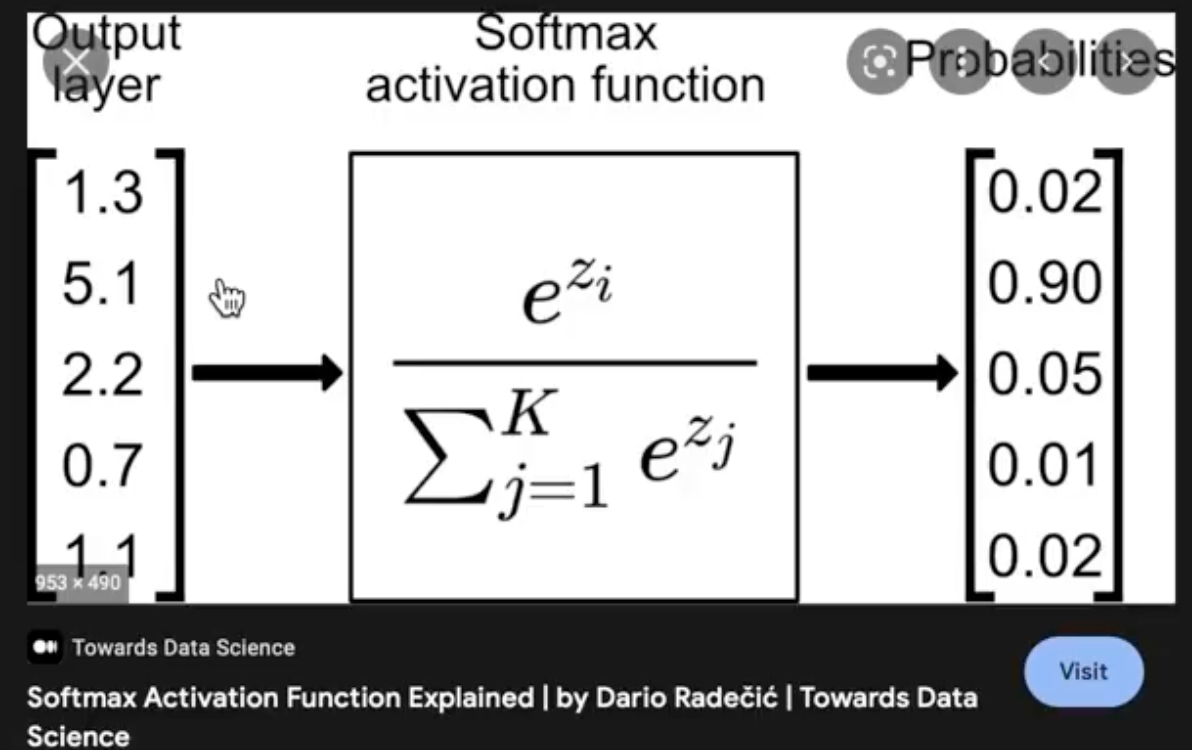

In [110]:
nlls = torch.zeros(5) # 이제 위의 예측의 loss들을 기록해보자.
for i  in range(5):
    x = xs[i].item()
    y = ys[i].item()
    
    p = probs[i,y] # i번째 input에 대해서 예측값을 확률화한것에서 y가 나올 확률
    logp = torch.log(p) #log likelihood
    nll = -logp
    nlls[i] = nll
nlls.mean().item() # average negative log likelihood
    

3.455498456954956

In [116]:
# neural network는 계속 parameter tuning하면서 loss를 줄인다.

# forward pass를 하고, prediction을 얻어서, loss를 잰다. back propagation을 한다. lr*gradient만큼 weight를 조정한다
# 우리의 loss는 nll

xs, ys = [] , [] #input, target label

## --- 초기세팅
for w in words[:1]: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

## --- 초기세팅

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad = True)

#forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

. e
e m
m m
m a
a .


In [126]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()
print(loss.item())

3.7291417121887207


In [117]:
probs[0,5], probs[1,13], probs[2,13], probs[3,1], probs[4,0] # 이게 우리의 예측되는결과물 (label) 
# 시작할땐 5번이 나오고
# 1번째문자로는 13번이 나오고
# 2번째문자로는 13번이 나오고 
# 3번째문자로는 1번이 나오고
# 4번째문자로는 0번이 나오고 했으면 좋겠다

(tensor(0.0123, grad_fn=<SelectBackward0>),
 tensor(0.0181, grad_fn=<SelectBackward0>),
 tensor(0.0267, grad_fn=<SelectBackward0>),
 tensor(0.0737, grad_fn=<SelectBackward0>),
 tensor(0.0150, grad_fn=<SelectBackward0>))

In [118]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [119]:
print(probs[torch.arange(5), ys]) # 우리의 label들로 probability 확인

loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)


tensor(3.7693, grad_fn=<NegBackward0>)

In [120]:
# backward pass
W.grad =None 
loss.backward()

In [122]:
W.grad, W.grad.shape # 27,27 # 우린 이 grad 정보를 가지고, W값을 조정해. W += - lr * W.grad

(tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
           0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
           0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
           0.0024,  0.0307,  0.0292],
         [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
           0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
           0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
           0.0131,  0.0101,  0.0018],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0

In [124]:
print(loss.item())

3.7693049907684326


In [125]:
W.data += -0.1*W.grad #이제 loss가 감소했을것. (forward 하면)
print(loss.item())

3.7693049907684326


In [131]:
xs, ys = [] , [] #input, target label

## --- 초기세팅
for w in words: #각 단어를 두개의 알파벳씩 slide하고싶어.
    chs = ["."] + list(w) + ['.'] # 
    for ch1, ch2 in zip(chs, chs[1:]): # zip은 둘중 하나의 list가 끝나면 iterating이 종료돼.
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num=xs.nelement()
## --- 초기세팅

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad = True)



In [133]:

# gradient descent
for k in range(10):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # logits은 one hot encoded vector라서, 그냥 picking up w 한줄 하는거야. 그래서 optimization의 end에는 저 위에서 정했던 count에 따른 array가 나올거야.
    counts = logits.exp()  # softmax 랑 동일 ( probs까지) 
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() # loss 에 regularization loss를 더할수도있다.
    print(loss.item())
    #backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

2.6890029907226562
2.6696884632110596
2.6529300212860107
2.638277769088745
2.6253879070281982
2.6139907836914062
2.60386323928833
2.5948216915130615
2.5867116451263428
2.579403877258301


In [135]:
(W**2).mean()

tensor(0.9905, grad_fn=<MeanBackward0>)

In [ ]:

# gradient descent
for k in range(10):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W # logits은 one hot encoded vector라서, 그냥 picking up w 한줄 하는거야. 그래서 optimization의 end에는 저 위에서 정했던 count에 따른 array가 나올거야.
    counts = logits.exp()  # softmax 랑 동일 ( probs까지) 
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # loss 에 regularization loss를 더할수도있다. 이 경우에 W의 값을 0에 가깝게 만드려는건데, 
    print(loss.item())
    #backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad
    
"""
만약, equivalent to smoothing.(N+1) 했던거 기억남?
근데 1을 더하는게 아니라 너무 많이 높이면 probs가 점점 uniform하게 돼. 

W를 0에 가깝게 만드는건 smoothing과 비슷한 느낌이야.
W가 0에 가까우면 counts는 다 1이되고, probs는 다 uniform하게 될테니까.

그런데 우리는 W가 0에 너무 가까워지지만 않으면, 좀더 smoothing 된 distribution을 제작할 수 있어. 그러니까 0.01정도로 조금만 더해.
그런데 0.01정도가 아니라 1씩 더하면, probability를 dominate해.

"""

In [140]:
#inference 하는법
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix =0
    while True:
        xenc = F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits = xenc @ W # predict log-count
        counts = logits.exp() # counts, equivalent to N
        p = counts/ counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix ==0:
            break
    print(''.join(out))
                        

moq.
axxaninaynnnykas.
kondn.
isah.
anchunizarie.
